In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_parquet('d4_10k_clust.parquet', engine='pyarrow')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Declare the constant batch size and get the data
batch_size = 128
x_data = torch.from_numpy(np.vstack(data['fingerprint'].values).astype(np.float32))
y_data = torch.Tensor(list(data['dockscore'].values))

# split the data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Regressors

In [ ]:
#Standard linear regressor
class Regressor(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Regressor, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)

    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, output_dim)

  def get_embedding(self, x):
    #Returns an embedding after the third layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def forward(self, x):
    emb = self.get_embedding(x)
    x = F.relu(emb)
    x = self.fc4(x)

    return x, emb

#Regressor using conv layers
class ConvRegressor(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.conv1 = nn.Conv1d(input_dim, 1512, 1)
    self.conv2 = nn.Conv1d(1512, 512, 1)

    self.fc1 = nn.Linear(512, 64)
    self.fc2 = nn.Linear(64, output_dim)

  def get_embedding(self, x):
    #Returns an embedding after the third layer
    x = torch.unsqueeze(x, 2) #needs to unsqueeze because the convolutional layer wants a third dimension
    x = F.relu(F.max_pool1d(self.conv1(x), 1))
    x = F.relu(F.max_pool1d(self.conv2(x), 1))

    x = x.view(-1, 512)

    x = self.fc1(x)

    return x

  def forward(self, x):
    emb = self.get_embedding(x)
    x = F.relu(emb)
    x = self.fc2(x)

    return x, emb

#Autoencoders

In [ ]:
#autoencoder with an auxiliary network to make a prediction about the dockscore
class AeMod(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(AeMod, self).__init__()
    self.enc1 = nn.Linear(input_dim, 256)
    self.enc2 = nn.Linear(256, 128)

    self.aux1 = nn.Linear(128, 64)
    self.aux2 = nn.Linear(64, output_dim)

    self.dec1 = nn.Linear(128, 256)
    self.dec2 = nn.Linear(256, input_dim)

  def encode(self, x):
    #Gets the encoding, returns at the bottleneck
    x = F.relu(self.enc1(x))
    x = self.enc2(x)

    return x
  
  def decode(self, x):
    #Takes in the bottleneck, reconstructs data based on the input
    x = F.relu(self.dec1(x))
    x = F.sigmoid(self.dec2(x))

    return x

  def aux(self, x):
    #Auxiliary network. Accepts the encoded data, makes a prediction about the dock score
    x = F.relu(self.aux1(x))
    x = self.aux2(x)

    return x

  def get_embedding(self, x):
    return self.encode(x)

  def forward(self, x):
    encoding = self.encode(x)
    aux = self.aux(encoding)
    decoding = self.decode(encoding)

    return aux, decoding #aux is the classification, decoding is a reconstructed output

#autoencoder without auxiliary network, using the bottleneck as the predictor
class AeModNoAux(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(AeModNoAux, self).__init__()
    self.enc1 = nn.Linear(input_dim, 128)
    self.enc2 = nn.Linear(128, output_dim)

    self.dec1 = nn.Linear(output_dim, 128)
    self.dec2 = nn.Linear(128, input_dim)

  def encode(self, x):
    x = F.relu(self.enc1(x))
    x = self.enc2(x)

    return x
  
  def decode(self, x):
    x = F.relu(self.dec1(x))
    x = F.sigmoid(self.dec2(x))

    return x

  #This encoding doesnt use the bottleneck because the bottleneck is only a single value
  def get_embedding(self, x):
    return self.enc1(x)

  def forward(self, x):
    encoding = self.encode(x)
    decoding = self.decode(encoding)


    
    return encoding, decoding


#cGAN

In [ ]:
#Generator for cGan

class Generator(nn.Module):
  def __init__(self, nz, out_size):
    super(Generator, self).__init__()
    self.nz = nz
    self.fc1 = nn.Linear(self.nz + out_size, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 768)
    self.fc4 = nn.Linear(768, 1024)

  def forward(self, x, label):
    
    label = torch.unsqueeze(label, 1)
    x = F.relu(self.fc1(torch.cat((x, label), 1)))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.sigmoid(self.fc4(x))

    return x

#Discriminator for cGan
class Discriminator(nn.Module):
  def __init__(self, out_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(1024 + out_size, 768)
    self.fc2 = nn.Linear(768, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)

  def forward(self, x, label):
    x = F.relu(self.fc1(torch.cat((x, label), 1)))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.sigmoid(self.fc4(x))

    return x


#Training Functions

In [ ]:
#trains a cGAN
def train_gan(generator, discriminator, epochs, nz = 25):
  optimizer_G = torch.optim.Adam(generator.parameters())
  optimizer_D = torch.optim.Adam(discriminator.parameters())
  
  criterion = nn.BCELoss()
  # crit_bce = nn.BCELoss()

  for epoch in range(epochs):
    for index, (x, y) in enumerate(train_loader):
      x = x.to(device)
      y = y.to(device)

      z = Variable(torch.randn((len(y), nz), device=device))
      z = torch.clamp(z, 1e-8, 1)
      fake_labels = Variable(torch.zeros(len(y), 1, device = device))
      real_labels = Variable(torch.ones(len(y), 1, device = device))

      #train generator

      optimizer_G.zero_grad()

      gen_imgs = generator(z, y)

      validity = discriminator(gen_imgs[gen_imgs > 0.5], real_labels)
      g_loss = criterion(validity, real_labels)

      g_loss.backward()
      optimizer_G.step()

      #train discriminator

      optimizer_D.zero_grad()

      validity_real = discriminator(x, torch.unsqueeze(y, 1))
      d_real_loss = criterion(validity_real, real_labels)

      validity_fake = discriminator(gen_imgs[gen_imgs > 0.5].detach(), torch.unsqueeze(y, 1))
      d_fake_loss = criterion(validity_fake, fake_labels)

      d_loss = (d_real_loss + d_fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()

    if epoch % 100 == 0:
      print('Epoch: {} \t Gen loss: {} \t Dis loss: {}'.format(epoch, g_loss, d_loss))

#gets the MSE of the test loader
def eval(model):
  criterion = nn.MSELoss()
  losses = []
  with torch.no_grad():
    for x, y in test_loader:
      x = x.to(device)
      y = y.to(device)

      pred_doc, embedding = model(x)
      pred_doc = torch.squeeze(pred_doc)
      y = torch.squeeze(y)
      loss = criterion(pred_doc, y)
      losses.append(loss.item())
  return np.mean(losses)

#trains a regressor
def train_reg(model, epochs):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = 3e-2)
  

  for i in range(epochs):
    for index, (x, y) in enumerate(train_loader):
      x = Variable(x).to(device)
      y = Variable(y).to(device)

      optimizer.zero_grad()
      pred_doc, embedding = model(x)
      pred_doc = torch.squeeze(pred_doc)
      y = torch.squeeze(y)
      loss = criterion(pred_doc, y)
      loss.backward()
      optimizer.step()

    if i % 100 == 0:
      eval_loss = eval(model)
      print('At epoch {} eval loss is: {}'.format(i, eval_loss))

#trains an autoencoder
def train_Ae(model, epochs):
  criterion_aux = nn.MSELoss()
  criterion_dec = nn.BCELoss()
  optimizer = optim.Adam(model.parameters())

  for i in range(epochs):
    for index, (x, y) in enumerate(train_loader):
      x = Variable(x).to(device)
      y = Variable(y).to(device)
      optimizer.zero_grad()
      prediction, reconstruction = model(x)
      loss_aux = criterion_aux(prediction, y)
      loss_dec = criterion_dec(reconstruction, x)
      loss = loss_aux + loss_dec
      loss.backward()
      optimizer.step()

    if i % 100 == 0:
      eval_loss = eval(model)
      print('At epoch {} eval loss is: {}'.format(i, eval_loss))





#Training

In [ ]:
my_model = Regressor(data['fingerprint'][0].shape[0], 1)
my_model = my_model.to(device)

In [ ]:

train_reg(my_model, 1000)

At epoch 0 eval loss is: 207.7000701904297
At epoch 100 eval loss is: 223.84518636067708
At epoch 200 eval loss is: 220.1985656738281
At epoch 300 eval loss is: 260.5677480061849
At epoch 400 eval loss is: 287.44187723795574
At epoch 500 eval loss is: 238.4124298095703
At epoch 600 eval loss is: 257.8174631754557
At epoch 700 eval loss is: 254.94509684244792
At epoch 800 eval loss is: 268.38206481933594
At epoch 900 eval loss is: 291.6500274658203


In [ ]:
conv_model = ConvRegressor(1024, 1)
conv_model = conv_model.to(device)

In [ ]:
train_reg(conv_model, 1000)

At epoch 0 eval loss is: 211.0418904622396
At epoch 100 eval loss is: 298.6409149169922
At epoch 200 eval loss is: 247.4049865722656
At epoch 300 eval loss is: 271.8082529703776
At epoch 400 eval loss is: 255.977885945638
At epoch 500 eval loss is: 274.5608612060547
At epoch 600 eval loss is: 244.39238789876302
At epoch 700 eval loss is: 243.109331258138
At epoch 800 eval loss is: 302.8934326171875
At epoch 900 eval loss is: 262.2111368815104


In [ ]:
Ae_model = AeMod(1024, 1)
Ae_model = Ae_model.to(device)

In [ ]:
train_Ae(Ae_model, 1000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([94])) that is different to the input size (torch.Size([94, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


At epoch 0 eval loss is: 400.40574340820314
At epoch 100 eval loss is: 405.2843729654948
At epoch 200 eval loss is: 406.10926513671876
At epoch 300 eval loss is: 404.1911356608073
At epoch 400 eval loss is: 402.30994669596356
At epoch 500 eval loss is: 413.3569051106771
At epoch 600 eval loss is: 403.1729309082031
At epoch 700 eval loss is: 410.35064290364585
At epoch 800 eval loss is: 407.1918884277344
At epoch 900 eval loss is: 406.6883076985677


In [ ]:
Ae_model_no_aux = AeModNoAux(1024, 1)
Ae_model_no_aux = Ae_model_no_aux.to(device)
train_Ae(Ae_model_no_aux, 1000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([94])) that is different to the input size (torch.Size([94, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


At epoch 0 eval loss is: 700.1113932291667
At epoch 100 eval loss is: 412.8665812174479
At epoch 200 eval loss is: 410.42405802408854
At epoch 300 eval loss is: 409.55820922851564
At epoch 400 eval loss is: 409.6105102539062
At epoch 500 eval loss is: 409.624550374349
At epoch 600 eval loss is: 409.59204915364586
At epoch 700 eval loss is: 409.5637919108073
At epoch 800 eval loss is: 409.5470743815104
At epoch 900 eval loss is: 409.53871459960936


In [ ]:
nz = 25
generator = Generator(nz, 1)
discriminator = Discriminator(1)
generator = generator.to(device)
discriminator = discriminator.to(device)
train_gan(generator, discriminator, epochs = 1000, nz = nz)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	 Gen loss: 5.674338340759277 	 Dis loss: 0.0002001623943215236
Epoch: 100 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 200 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 300 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 400 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 500 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 600 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 700 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 800 	 Gen loss: 100.0 	 Dis loss: 0.0
Epoch: 900 	 Gen loss: 100.0 	 Dis loss: 0.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#t-SNE/PCA with Plots

In [ ]:
#Runs t-SNE on data embeded by the input model, graphs the components
def get_tsne(model, loader, components, title):
  embeddings = []
  for x, _ in loader:
    x = x.to(device)
    embed = model.get_embedding(x)
    embeddings.append(embed.detach().cpu().numpy())
  embeddings = np.concatenate(embeddings, 0)
  X_embedded = TSNE(n_components=components).fit_transform(embeddings)

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Embedding 1', fontsize = 15)
  ax.set_ylabel('Embedding 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#Runs PCA on data embeded by the input model, graphs the components
def get_pca(model, loader, components, title):
  pca = PCA(n_components=components)
  embeddings = []
  for x, _ in loader:
    x = x.to(device)
    embed = model.get_embedding(x)
    embeddings.append(embed.detach().cpu().numpy())
  embeddings = np.concatenate(embeddings, 0)
  pca.fit(embeddings)

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  ax.scatter(pca.components_[0,: ], pca.components_[1,: ])

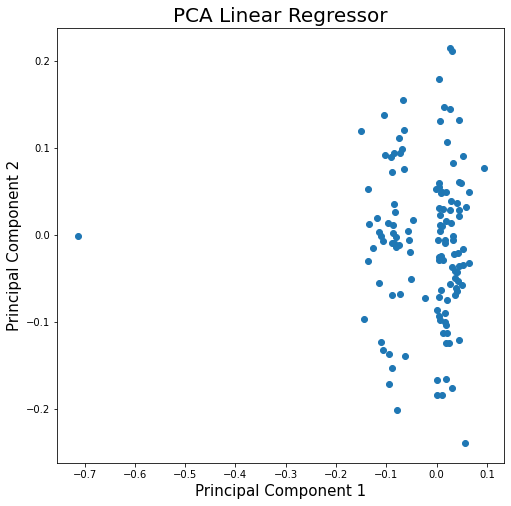

In [ ]:
get_pca(my_model, test_loader, components = 2, title = 'PCA Linear Regressor')


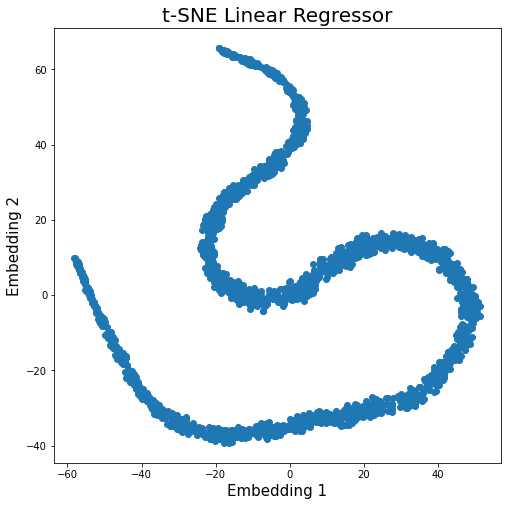

In [ ]:
get_tsne(my_model, test_loader, components = 2, title = 't-SNE Linear Regressor')


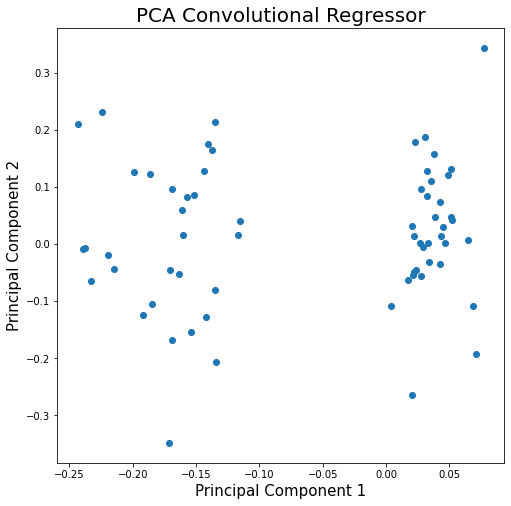

In [ ]:
get_pca(conv_model, test_loader, components = 2, title = 'PCA Convolutional Regressor')

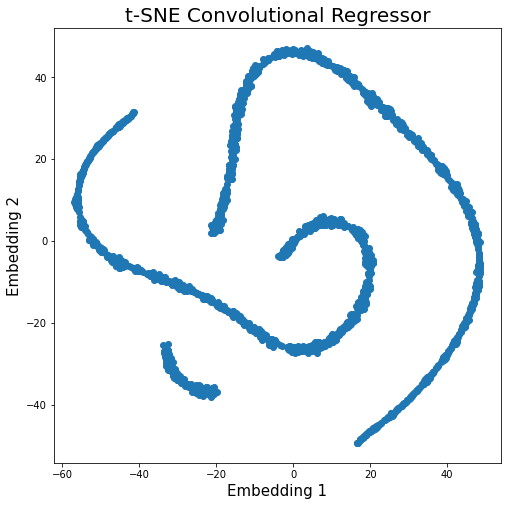

In [ ]:
get_tsne(conv_model, test_loader, components = 2, title = 't-SNE Convolutional Regressor')

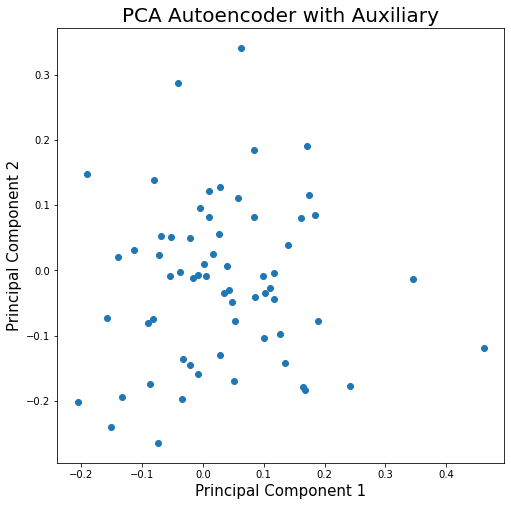

In [ ]:
get_pca(Ae_model, test_loader, components = 2, title = 'PCA Autoencoder with Auxiliary')

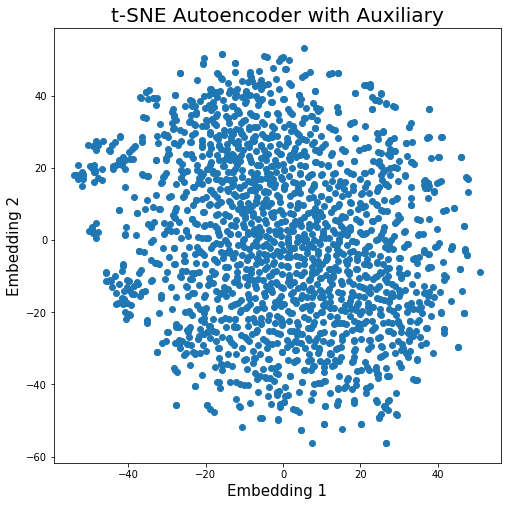

In [ ]:
get_tsne(Ae_model, test_loader, components = 2, title = 't-SNE Autoencoder with Auxiliary')

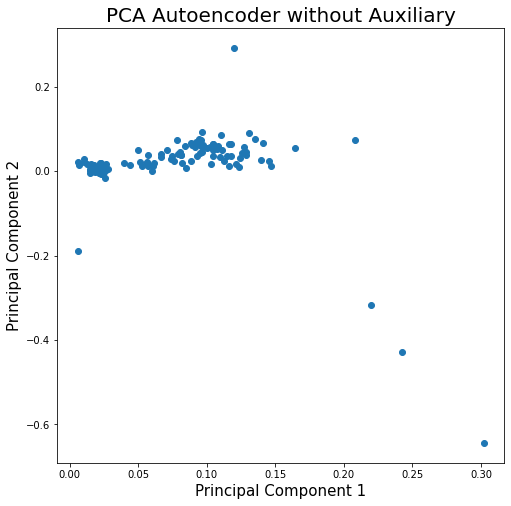

In [ ]:
get_pca(Ae_model_no_aux, test_loader, components = 2, title = 'PCA Autoencoder without Auxiliary')

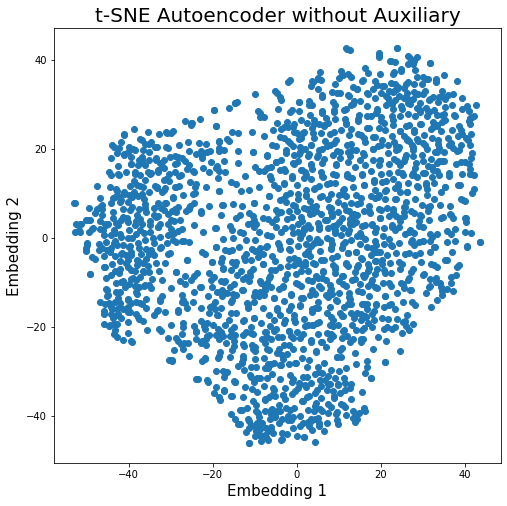

In [ ]:
get_tsne(Ae_model_no_aux, test_loader, components = 2, title = 't-SNE Autoencoder without Auxiliary')